In [1]:
import pandas as pd

df = pd.read_csv("/home/ajeet/Sourav/aug_data.csv")

In [2]:
df.drop(columns=["Unnamed: 0.1", "Unnamed: 0", "subject_ID"], axis=1, inplace=True)
df.fillna("<PAD>", inplace=True)
df = df.astype({'text': str, 'Anorexia': int})
print(df.dtypes)
print(df.head())

text        object
Anorexia     int64
dtype: object
                                                text  Anorexia
0   [pc] [h] 4 keys maybe 5? [w] endo    so why d...         0
1      Because he saw a movie once?     It's Cana...         0
2   What book should I read next that will scare ...         0
3      ''I only drink soda at parties''     Are y...         0
4      Once I named myself 'pros solo', the numbe...         0


In [3]:
import re

def remove_urls(text):
    # Define the pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    # Replace URLs with an empty string
    text_without_urls = url_pattern.sub('', text)
    text_wihtout_urls = ''.join(filter(lambda x: x.isalpha() or x.isdigit() or x.isspace(), text_without_urls))
    return text_without_urls

In [4]:
def split_text_into_subtexts(text, max_length):
    subtexts = []
    words = text.split()
    current_subtext = ''
    for word in words:
        if word == ' ':
            continue
        if len(current_subtext) + len(word) < max_length:
            current_subtext += ' ' + word
        else:
            subtexts.append(current_subtext.strip())
            current_subtext = word
    if current_subtext:
        subtexts.append(current_subtext.strip())
    return subtexts

In [5]:
import re

def clean_text(text):
    # Remove URLs
    text = re.sub(R"https?://\S+|www\.\S+", "", text)
    # Remove brackets (both round and square brackets)
    text = re.sub(r"[\(\)\[\]\{\}]", "", text)
    # Remove punctuation marks and non-word characters
    text = re.sub(r"[^\w\s]", "", text)
    return text

In [6]:
import warnings
warnings.filterwarnings("ignore")

for i in range(0, len(df)):
    df['text'][i] = clean_text(remove_urls(df['text'][i]))
df.head()

,text,Anorexia
0,pc h 4 keys maybe 5 w endo so why does my ...,0
1,Because he saw a movie once Its Canadi...,0
2,What book should I read next that will scare ...,0
3,I only drink soda at parties Are you e...,0
4,Once I named myself pros solo the number o...,0


In [7]:
df = df.astype({'text': str, 'Anorexia': int})
print(df.dtypes)

text        object
Anorexia     int64
dtype: object


In [8]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Perform an 80:20 train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Create Dataset objects for train and test sets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [9]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", cache_dir = '/home/ajeet/Sourav/pre_trained_weigths')

In [10]:
from torch import Tensor

def split_overlapping(tensor: Tensor, chunk_size: int, stride: int, minimal_chunk_length: int):
    input_ids = tensor["input_ids"].squeeze(0)
    attn_mask = tensor["attention_mask"].squeeze(0)
    result_input_id = [input_ids[i: i+chunk_size] for i in range(0, len(input_ids), stride)]
    result_attn_mask = [attn_mask[i: i+chunk_size] for i in range(0, len(attn_mask), stride)]
    if len(result_input_id) > 1:
        result_input_id = [x for x in result_input_id if len(x) >= minimal_chunk_length]
        result_attn_mask = [x for x in result_attn_mask if len(x) >= minimal_chunk_length]
    return result_input_id, result_attn_mask

In [11]:
import torch

def add_special_tokens(input_id_chunks: list[Tensor], mask_chunks: list[Tensor]):
    for i in range(len(input_id_chunks)):
        input_id_chunks[i] = torch.cat([Tensor([101]), input_id_chunks[i], Tensor([102])])
        mask_chunks[i] = torch.cat([Tensor([1]), mask_chunks[i], Tensor([1])])

In [12]:
def add_padding(input_id_chunks: list[Tensor], mask_chunks: list[Tensor]):
    for i in range(len(input_id_chunks)):
        pad_len = 512 - input_id_chunks[i].shape[0]
        if pad_len > 0:
            input_id_chunks[i] = torch.cat([input_id_chunks[i], Tensor([0]*pad_len)])
            mask_chunks[i] = torch.cat([mask_chunks[i], Tensor([0]*pad_len)])

In [13]:
def stack_tokens(input_id_chunks: list[Tensor], mask_chunks: list[Tensor]):
    input_ids = torch.stack(input_id_chunks)
    attn_mask = torch.stack(mask_chunks)
    return input_ids.long(), attn_mask.int()

In [14]:
from transformers import PreTrainedTokenizerBase

def transform_single_text(text: str, tokenizer: PreTrainedTokenizerBase,
                          chunk_size: int, stride: int, minimal_chunk_length: int):
    tokens = tokenizer(text, add_special_tokens=False, truncation=False, return_tensors="pt")
    input_id_chunks, mask_chunks = split_overlapping(tokens, chunk_size, stride, minimal_chunk_length)
    add_special_tokens(input_id_chunks, mask_chunks)
    add_padding(input_id_chunks, mask_chunks)
    input_ids, attention_mask = stack_tokens(input_id_chunks, mask_chunks)
    return input_ids, attention_mask


In [15]:
input_ids, attn_mask = transform_single_text(df["text"][145], tokenizer, 510, 510, 1)
print(input_ids.shape, attn_mask.shape)

Token indices sequence length is longer than the specified maximum sequence length for this model (6325 > 512). Running this sequence through the model will result in indexing errors


torch.Size([13, 512]) torch.Size([13, 512])


In [16]:
def tokenize_data(example):
    input_ids, attn_mask = transform_single_text(example["text"], tokenizer, 510, 510, 1)
    return {'input_ids': input_ids, 'attention_mask': attn_mask, 'label':example['Anorexia']}

tokenized_dataset = train_dataset.map(tokenize_data, batched=False)
tokenized_dataset_test = test_dataset.map(tokenize_data, batched=False)

Map: 100%|██████████| 740/740 [00:24<00:00, 30.14 examples/s]


In [17]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, cache_dir="/home/ajeet/Sourav/pre_trained_weigths")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
for x in train_dataset:
    print(x)
    break

{'text': '    it might just be because its a photo of the work  but i dont think his nose looks to long just my 2 cents      bird over mountains  white and vine charcoal     landscape abstraction       the drawing was of a mirror in a box with holes in it reflecting another mirror that was aimed at a window so just kinda ran with the cube box concept         i used charcoal  vine  stick  and powder  and the highlights are white charcoal  abstract reflections   ', 'Anorexia': 1, '__index_level_0__': 2887}


In [22]:
Device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Device = 'cpu'
model.to(Device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
criterion = torch.nn.BCELoss()
num_epochs = 30

In [20]:
# TORCH_USE_CUDA_DSA
for x in tokenized_dataset:
    # for i in range(0, len(x['input_ids'])):
    # print(x['text'])
    tokens = {'input_ids': torch.LongTensor(x['input_ids']).to(Device), 'attention_mask': torch.LongTensor(x['attention_mask']).to(Device)}
    output = model(**tokens)
    # print(output)
    output = torch.nn.functional.softmax(output.logits, dim=-1)
    # print(output)
    output = output[:, 1].mean()
    print(output.unsqueeze(0), torch.tensor(x['Anorexia']).unsqueeze(0))
    break


tensor([0.5208], device='cuda:0', grad_fn=<UnsqueezeBackward0>) tensor([1])


In [26]:
len(tokenized_dataset)

2957

In [25]:
model.load_state_dict(torch.load('./ckpt/model_best.pt'))
model = model.to(Device)

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
import os


best_val_loss = 0.1422
model.train()
for epoch in range(num_epochs):
    loss_train = 0
    for data in tqdm(tokenized_dataset, desc=f"training epoch = {epoch}"):
        optimizer.zero_grad()
        labels = torch.tensor(data['Anorexia']).to(Device)
        probs = 0.0
        for i in range(0, len(data['input_ids'])):
            tokens = {'input_ids': torch.LongTensor(data['input_ids'][i]).to(Device), 'attention_mask': torch.LongTensor(data['attention_mask'][i]).to(Device)}
            output = model(**tokens)
            output = F.softmax(output.logits, dim=-1)
            output = output[:, 1].mean()
            loss = criterion(output.unsqueeze(0), labels.float().unsqueeze(0))
            loss.backward()
            probs += loss.item()
        probs = probs/len(data['input_ids'])
        loss_train += probs
        optimizer.step()
    print(f"training_loss = {loss_train/len(tokenized_dataset)}")

    model.eval()
    val_loss = 0
    num_val_steps =  0
    with torch.no_grad():
        for data in tqdm(tokenized_dataset_test, desc=f"validation epoch = {epoch}"):
            labels = torch.tensor(data['Anorexia']).to(Device)
            probs = 0
            for i in range(0, len(data['input_ids'])):
                tokens = {'input_ids': torch.LongTensor(data['input_ids'][i]).to(Device), 'attention_mask': torch.LongTensor(data['attention_mask'][i]).to(Device)}
                output = model(**tokens)
                output = F.softmax(output.logits, dim=-1)
                output = output[:, 1].mean()
                loss = criterion(output.unsqueeze(0), labels.float().unsqueeze(0))
                probs += loss.item()
            probs = probs/len(data['input_ids'])
            val_loss += probs
            num_val_steps += 1
    val_loss /= num_val_steps

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(),
               os.path.join("/home/ajeet/Sourav/ckpt",
                            f"model_best.pt"))

    if (epoch+1)%10 == 0:
        torch.save(model.state_dict(),
               os.path.join("/home/ajeet/Sourav/ckpt",
                            f"epoch_{epoch+1}_val_loss_{val_loss}.pt"))

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Val loss: {val_loss:.4f}')

# Evaluation

In [1]:
import math

def get_delays(preds, delays_all):
    delays = []
    for i in range(0, len(preds)):
        delay = 0
        for j in range(0, len(preds[i])):
            if preds[i][j] == 1:
                # delay += delays_all[i][j]
                break
            delay += delays_all[i][j]
        delays.append(delay)
    return delays

import numpy as np

def lco(k, o):
    if k - o > 700:
        return 1.0
    elif k - o < -700:
        return 0.0
    else:
        return 1 - (1 / (1 + np.exp(k - o)))


def calculate_ERDE(preds, delays, ground_truth, cfn, ctp, o):
    cfp = np.sum(ground_truth)/len(ground_truth)
    erde_values = []
    for pred, gt, delay in zip(preds, ground_truth, delays):
        if pred == 1 and gt == 1:
            erde = lco(delay, o) * ctp 
        elif pred == 0 and gt == 1:
            erde = cfn
        elif pred == 1 and gt == 0:
            erde = cfp
        else:
            erde = 0
        erde_values.append(erde)
    return sum(erde_values) / len(erde_values)

In [2]:
import pandas as pd
testing_df = pd.read_csv("/home/ajeet/Sourav/test_data.csv")
testing_df.head()

,Unnamed: 0,subject_ID,num_writings,text,Anorexia
0,0,1152_1,4,Student at uw. Need a few hours away from cam...,1
1,1,1169_1,14,"Haha, nailed it dude.\n Rings are defi...",1
2,2,1441_1,55,"Right, which is why I said those people wo...",1
3,3,1518_1,31,I just have a lot of self hatred and depri...,1
4,4,1773_1,1,Thank you for your long reply! I have been...,1


In [3]:
testing_df.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
testing_df.fillna("<PAD>", inplace=True)
testing_df = testing_df.astype({'text': str, 'Anorexia': int})
print(testing_df.dtypes)
print(testing_df.head())

subject_ID      object
num_writings     int64
text            object
Anorexia         int64
dtype: object
  subject_ID  num_writings                                               text  \
0     1152_1             4   Student at uw. Need a few hours away from cam...   
1     1169_1            14      Haha, nailed it dude.\n     Rings are defi...   
2     1441_1            55      Right, which is why I said those people wo...   
3     1518_1            31      I just have a lot of self hatred and depri...   
4     1773_1             1      Thank you for your long reply! I have been...   

   Anorexia  
0         1  
1         1  
2         1  
3         1  
4         1  


In [ ]:
import warnings
warnings.filterwarnings("ignore")

for i in range(0, len(testing_df)):
    testing_df['text'][i] = clean_text(remove_urls(testing_df['text'][i]))
testing_df.head()

In [111]:
testing_df = testing_df.astype({'text': str, 'Anorexia': int})
print(testing_df.dtypes)

subject_ID      object
num_writings     int64
text            object
Anorexia         int64
dtype: object


#### single process

```
base_path = '/home/ajeet/Sourav/test_dataset'
for i in range(0, len(testing_df)):
    subject_id, chunk = testing_df["subject_ID"][i].split('_')
    input_ids, attn_mask = transform_single_text(testing_df['text'][i], tokenizer, 510, 510, 1)
    if not os.path.exists(os.join(base_path, chunk)):
        os.mkdir(os.path.join(base_path, chunk))
    os.mkdir(os.path.join(base_path, chunk, subject_id), exist=True)
    np.save(os.path.join(base_path, chunk, subject_id, 'input_ids.npy'), input_ids.numpy())
    np.save(os.path.join(base_path, chunk, subject_id, 'attn_mask.npy'), attn_mask.numpy())
```

#### Multiprocessing

In [39]:
import os
import numpy as np
from multiprocessing import Pool

base_path = '/home/ajeet/Sourav/test_dataset'

def process_data(i):
    subject_id, chunk = testing_df["subject_ID"][i].split('_')
    try: 
        input_ids, attn_mask = transform_single_text(testing_df['text'][i], tokenizer, 510, 510, 1)
        if not os.path.exists(os.path.join(base_path, chunk)):
            try: os.mkdir(os.path.join(base_path, chunk))
            except: pass
        if not os.path.exists(os.path.join(base_path, chunk, subject_id)):
            try: os.mkdir(os.path.join(base_path, chunk, subject_id))
            except: pass
        np.save(os.path.join(base_path, chunk, subject_id, 'input_ids.npy'), input_ids.numpy())
        np.save(os.path.join(base_path, chunk, subject_id, 'attn_mask.npy'), attn_mask.numpy())
        print("done\n")
    except: pass

# if __name__ == '__main__':
with Pool() as pool:
    pool.map(process_data, range(len(testing_df)))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

done
done
done


done
done
done

done
done
done
done
done

done
done
done
done
done
done

done
done



done





done

done

done

done
done
done

done
done
done
done

done
done
done
done
done






done

done
done


done


done



done
done

done




done
done

done
done


done
done

done









done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done

done
done

done
done
done
done
done



done


























done
done


done








done

done

done

done
done


done



done

done
done
done
done
done
done



done

done




done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done

done
done



done

































done



done
done


done


done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
don

In [6]:
# writings_dict = {}
# for i in range(0, len(testing_df)):
#     subject, chunk = testing_df['subject_ID'][i].split('_')
#     chunk = int(chunk)
#     if subject not in writings_dict.keys():
#         writings_dict[subject] = [0 for j in range(10)] 
#     writings_dict[subject][chunk-1] = testing_df['num_writings'][i]

delay_dict = dict(zip(testing_df['subject_ID'], testing_df['num_writings']))

In [7]:
d = {}
with open("/home/ajeet/Sourav/risk-golden-truth-test.txt", 'r') as f:
    for line in f:
        subject, label = line.split()
        d[subject[7:]] = int(label)

len(d)

320

In [16]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import random

class NpyDataset(Dataset):
    def __init__(self, npy_folder, labels_dict, delay_dict):
        self.npy_folder = npy_folder
        self.labels_dict = labels_dict
        self.delay_dict = delay_dict
        self.my_list = glob(os.path.join(npy_folder, "*"))
        file_names = glob(os.path.join(self.my_list[0], '*'))
        self.file_names = random.sample(file_names, len(file_names))

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        file_path_list = []
        delay_list = []
        file_path = self.file_names[idx]
        file = file_path.split('/')[-1]
        for i in range(1, 11):
            file_path_list.append(os.path.join(self.npy_folder, str(i), file))
            try:
                delay = self.delay_dict[file.split('.')[0] + '_' + str(i)]
                # print(np.array(time).shape)
                delay_list.append(delay)

            except:   
                delay_list.append(0)
            
        subject = file_path.split('/')[-1].split('.')[0]
        label = self.labels_dict[subject]

        return file_path_list, delay_list, label

In [17]:
test_dataset = NpyDataset('/home/ajeet/Sourav/test_dataset', d, delay_dict)
for path_list, label, num_writing in test_dataset:
    # path_list.sort()
    print(path_list)
    print(label)
    print(num_writing)
    break

['/home/ajeet/Sourav/test_dataset/1/536', '/home/ajeet/Sourav/test_dataset/2/536', '/home/ajeet/Sourav/test_dataset/3/536', '/home/ajeet/Sourav/test_dataset/4/536', '/home/ajeet/Sourav/test_dataset/5/536', '/home/ajeet/Sourav/test_dataset/6/536', '/home/ajeet/Sourav/test_dataset/7/536', '/home/ajeet/Sourav/test_dataset/8/536', '/home/ajeet/Sourav/test_dataset/9/536', '/home/ajeet/Sourav/test_dataset/10/536']
[12, 12, 12, 12, 12, 12, 12, 12, 12, 15]
1


In [42]:
import torch.nn.functional as F
def evaluate(test_dataset, model):
    probs, num_writings, target = [], [], []
    model.to(Device)
    model.eval()
    with torch.no_grad():
        for features, num_writing, label in tqdm(test_dataset):
            temp = []
            for feature in features:
                try:
                    input_ids = np.load(os.path.join(feature, 'input_ids.npy'))
                    attn_mask = np.load(os.path.join(feature, 'attn_mask.npy'))
                    logit = 0
                    for i in range(0, len(input_ids)):
                        tokens = {'input_ids': torch.LongTensor(input_ids[i]).to(Device), 
                                    'attention_mask': torch.LongTensor(attn_mask[i]).to(Device)}
                        output = model(**tokens)
                        output = F.softmax(output.logits, dim=-1)
                        output = output[:, 1].mean()
                        logit += output.item()
                    logit = logit/len(input_ids)
                    temp.append(logit)
                except:
                    temp.append(0)
            target.append(label)
            probs.append(temp)
            num_writings.append(num_writing)

    return np.array(probs), np.array(target), np.array(num_writings)

In [32]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, cache_dir="/home/ajeet/Sourav/pre_trained_weigths")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
Device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [34]:
# model.load_state_dict(torch.load("/media/souravsaini/Data/POP_OS/internship/models_wts/longformer/Aug_dataset/epoch_49_val_loss_0.1539282605572142.pt"))
model.load_state_dict(torch.load("/home/ajeet/Sourav/ckpt/model_best.pt"))
model = model.to(Device)

In [43]:
from tqdm import tqdm
probs, label, delay = evaluate(test_dataset, model)

100%|██████████| 320/320 [01:35<00:00,  3.35it/s]


In [41]:
delay

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

      threshold  f1_score
0         0.000  0.227147
1         0.001  0.227147
2         0.002  0.229050
3         0.003  0.246988
4         0.004  0.276094
...         ...       ...
1005      1.005  0.000000
1006      1.006  0.000000
1007      1.007  0.000000
1008      1.008  0.000000
1009      1.009  0.000000

[1010 rows x 2 columns]


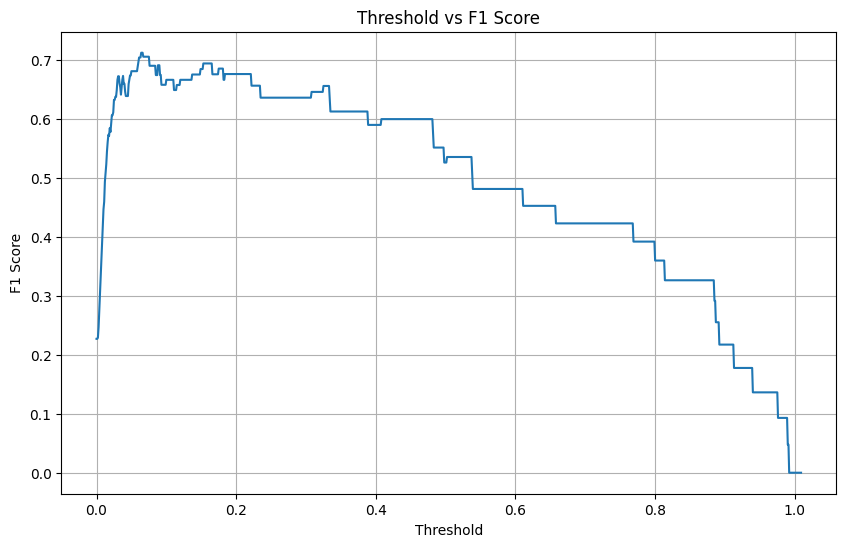

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Initialize lists to store results
thresholds = np.arange(0, 1.01, 0.001)
f1_scores = []

# Calculate F1 score for each threshold
for threshold in thresholds:
    pred_labels = []
    for i in range(len(probs)):
        temp = []
        for j in range(len(probs[i])):
            if probs[i][j] > threshold: 
                temp.append(1)
            else: 
                temp.append(0)
        pred_labels.append(temp)

    preds = []
    for i in pred_labels:
        if sum(i) > 7: 
            preds.append(1)
        else: 
            preds.append(0)
    
    f1 = f1_score(label, preds)
    f1_scores.append(f1)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'threshold': thresholds,
    'f1_score': f1_scores
})

# Print the DataFrame
print(results_df)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['f1_score'])
plt.title('Threshold vs F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


In [45]:
results_df.to_csv("/home/ajeet/Sourav/threshold_vs_f1/bert_sentiment.csv")

In [136]:
pred_labels = []
for i in range(0,len(probs)):
    temp = []
    for j in range(0, len(probs[i])):
        if probs[i][j]>=0.45: temp.append(1)
        else: temp.append(0)
    pred_labels.append(temp)

In [137]:
pred_labels

[[0, 0, 0, 1, 0, 1, 1, 1, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 1, 1, 1, 1, 1, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
 [0, 0, 1, 0, 0, 1, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 1, 1, 0, 1, 0, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0,

In [138]:
delays = get_delays(pred_labels, num_writings)
print(delays)

[75, 160, 1151, 1402, 380, 0, 72, 83, 144, 944, 165, 503, 1108, 5, 2, 1999, 65, 1034, 30, 5, 50, 60, 52, 1241, 183, 328, 1688, 0, 436, 22, 468, 1017, 88, 87, 38, 177, 674, 74, 1121, 608, 1746, 204, 102, 12, 0, 1800, 454, 162, 10, 1159, 388, 57, 0, 0, 382, 12, 784, 1497, 0, 32, 224, 504, 317, 99, 541, 30, 255, 2, 200, 958, 2, 6, 1001, 26, 1182, 25, 57, 119, 888, 1173, 1245, 299, 3, 628, 420, 1514, 935, 803, 6, 1037, 245, 480, 0, 109, 663, 1276, 0, 844, 1031, 10, 790, 171, 21, 1095, 46, 60, 956, 1192, 6, 453, 1025, 0, 532, 1766, 90, 170, 87, 1234, 1439, 0, 54, 1279, 1210, 612, 104, 18, 1988, 646, 1193, 452, 573, 1216, 438, 347, 67, 340, 51, 1006, 42, 1706, 50, 1919, 128, 0, 1207, 96, 0, 549, 90, 0, 1, 75, 0, 0, 695, 575, 1145, 110, 223, 1742, 1294, 5, 75, 538, 1108, 1188, 538, 10, 335, 49, 165, 548, 68, 1036, 2, 4, 221, 164, 45, 383, 1167, 469, 1263, 24, 1, 581, 659, 160, 1207, 34, 78, 1191, 147, 773, 5, 0, 79, 4, 705, 110, 3, 994, 43, 268, 126, 1148, 319, 102, 662, 369, 80, 106, 1332, 1

In [139]:
preds = np.array(pred_labels).flatten()
labels = np.array([label for i in range(10)]).transpose().flatten()

precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
print(f"precision = {precision}\nrecall = {recall}")

precision = 0.6714697406340058
recall = 0.5682926829268292


In [141]:
preds_erde = []
for i in pred_labels:
    if sum(i)>0: preds_erde.append(1)
    else: preds_erde.append(0)

cfp = 0.01  # Cost of false positive
cfn = 1     # Cost of false negative
ctp = 1     # Cost of true positive
o = 5       # Parameter controlling the rate of increase for latency cost
ERDE5 = calculate_ERDE(preds_erde, delays, label, cfn, ctp, o)
ERDE50 = calculate_ERDE(preds_erde, delays, label, cfn, ctp, o*10)
print(f"ERDE5 = {ERDE5*100}%\nERDE50 = {ERDE50*100}%")

ERDE5 = 8.103633124140051%
ERDE50 = 5.954937293216693%
